In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Shaded(object):
    def __init__(self):
        self.G = [100, 1000]  # read irradiance # Solar radiation in mW / sq.cm / Esto es la irradiancia para panel cuando [sombredo,sin_sombra]
        #self.T = 25  # read temperature # ojo con kelvin 273
        #self.SH = [4, 10, 7, 10, 10, 10]  # Shaded modules
        self.Mp = 10  # Modules in parallel
        self.Ng = [40, 38, 22]  # Parallel-connected series assemblies
        self.Iscr_sh = 0.375

    def data(self, Irradiancia_maxima, T, V, SH):

        # G_ar = np.array(G) # Solar radiation in mW/sq.cm

        pv = Panel()
        IUN = []
        ISH = []
        Ipv = []

        for j in range(len(self.Ng)):
            # IUN_i = pv.calc_pv(Irradiancia_maxima, T, V, SH[j*2])[0] # asi estaria bien hecho, pero como dejamos fija la irradiancia maxima lo tomamos del self.G[1]
            IUN_i = pv.calc_pv(self.G[1], T, V, SH[j*2])[0]
            if IUN_i < 0:
                IUN_i = 0
            IUN.append(IUN_i)
            ISH_i = pv.calc_pv(self.G[0], T, V, SH[j*2+1])[0]
            if ISH_i< 0:
                ISH_i = 0
            ISH.append(ISH_i)

        for jj in (range(len(self.Ng))):
            if IUN[jj] > self.Iscr_sh:
                Ipv.append(IUN[jj])
            else:
                Ipv.append(ISH[jj])

        
        IT = Ipv[0] * self.Ng[0] + Ipv[1] * self.Ng[1] + Ipv[2] * self.Ng[2]
        VT = V
        PT = IT*VT
        return IT, VT, PT 

class Panel(object):

    def __init__(self):
        self.TK = 273 # Kelvin temperature
        self.Tr1 = 40  # Reference temperature in degree fahrenheit
        # self.S = 100  # Solar radiation in mW / sq.cm
        self.ki = 0.00023  # in A / K
        self.Iscr = 3.75  # SC Current at ref.temp. in A
        self.Irr = 0.000021  # in A
        self.k = 1.38065e-23  # Boltzmann constant
        self.q = 1.6022e-19  # charge of an electron
        self.A = 2.15 # ideality factor
        self.Eg0 = 1.166 # band gap energy
        self.alpha = 0.473
        self.beta = 636
        # panel composed of Np parallel modules each one including Ns photovoltaic cells connected
        self.Np = 1
        self.Ns = 36

    def calc_pv(self, G, T, vx, SH):
        # cell temperature
        Tcell = T + self.TK
        # cell reference temperature in kelvin
        Tr = ((self.Tr1 - 32) * (5 / 9)) + 273
        # band gap energy of semiconductor
        Eg = self.Eg0 - (self.alpha * Tcell * Tcell) / (Tcell + self.beta) * self.q
        # generated photocurrent
        Iph = (self.Iscr + self.ki * (Tcell - Tr)) * (G / 1000)
        # cell reverse saturation current
        Irs = self.Irr * ((Tcell / Tr) ** 3) * np.exp(self.q * Eg / (self.k * self.A) * ((1 / Tr) - (1 / Tcell)))
        # panel output current
        I = self.Np * Iph - self.Np * Irs * (np.exp(self.q / (self.k * Tcell * self.A) * vx * (1/SH) / self.Ns) - 1)
        # panel output voltage
        V = vx # este es el Vg?
        # panel power
        P = vx * I

        return I,V,P

Voltage = 0.
Power = 0.

# Temp = 25.
# Irr = 1000.
# a = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
# b = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
# c = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
# # a = 4
# # b = 7
# # c = 10
# SH = [a, 10, b, 10, c, 10]

# powerlst = []
# voltagelst = []

# for i in range(30000):
#     Voltage += 0.01
#     pv = Shaded()
#     Current, Voltage, Power = pv.data(Irr, Temp, Voltage, SH)
#     powerlst.append(Power)
#     voltagelst.append(Voltage)

# plt.plot(voltagelst, powerlst)

In [2]:
class Mppt():
    def _get_obs(self):
        return {"Voltage" : self._Voltage, "Power" : self._Power, "deltaPower" : self._deltaPower}
    
    def _get_info(self):
        return {"Steps" : self._Steps, "Current" : self._Current, "Temperature" : self._Temp, "Irradiance" : self._Irr, "Shading" : self._SH}
        
    def reset(self):
        self._Voltage = 0.
        self._Power = 0.
        self._deltaPower = 0.
        observation = self._get_obs()

        self._Steps = 0
        self._Current = 0.
        self._Temp = 25.
        self._Irr = 1000.
        a = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
        b = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
        c = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
        self._SH = [a, 10, b, 10, c, 10]
        info = self._get_info()

        return observation, info
    
    def step(self, action):
        self._Steps += 1
        self._Voltage += action
        oldP = self._Power

        # PVobj = PV(self._Irr, self._Temp, self._SH, self._Voltage)
        # self._Current, self._Voltage, self._Power = PVobj.array()

        pv = Shaded()
        self._Current, self._Voltage, self._Power = pv.data(self._Irr, self._Temp, self._Voltage, self._SH)

        self._deltaPower = self._Power - oldP
        # done = bool(self._Steps>=self._Max_steps)

        # reward = self.reward_function(self._Power, done)
        reward = self.reward_function()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, False, info

    def reward_function(self):
        return self._Power
    
    def render(self):
        pass

    def close(self):
        pass
    
    ### Temporary
    def setTempIrr(self,last_state,T,G,SH):
        self.Temp = T
        self.Irr = G
        self.SH = SH
        return last_state

In [3]:
mppt1 = Mppt()

In [4]:
mppt1.reset()

({'Voltage': 0.0, 'Power': 0.0, 'deltaPower': 0.0},
 {'Steps': 0,
  'Current': 0.0,
  'Temperature': 25.0,
  'Irradiance': 1000.0,
  'Shading': [9, 10, 7, 10, 2, 10]})

In [5]:
# mppt1.step(0.01)

In [6]:
voltlst = []
powlst = []
for i in range(212):
    print(mppt1.step(1), '\n')
    voltlst.append(mppt1._get_obs()["Voltage"])
    powlst.append(mppt1._get_obs()["Power"])

({'Voltage': 1.0, 'Power': 375.4713563995136, 'deltaPower': 375.4713563995136}, 375.4713563995136, False, {'Steps': 1, 'Current': 375.4713563995136, 'Temperature': 25.0, 'Irradiance': 1000.0, 'Shading': [9, 10, 7, 10, 2, 10]}) 

({'Voltage': 2.0, 'Power': 750.9393367457894, 'deltaPower': 375.46798034627585}, 750.9393367457894, False, {'Steps': 2, 'Current': 375.4696683728947, 'Temperature': 25.0, 'Irradiance': 1000.0, 'Shading': [9, 10, 7, 10, 2, 10]}) 

({'Voltage': 3.0, 'Power': 1126.4029402221167, 'deltaPower': 375.4636034763273}, 1126.4029402221167, False, {'Steps': 3, 'Current': 375.4676467407056, 'Temperature': 25.0, 'Irradiance': 1000.0, 'Shading': [9, 10, 7, 10, 2, 10]}) 

({'Voltage': 4.0, 'Power': 1501.8608240949857, 'deltaPower': 375.45788387286893}, 1501.8608240949857, False, {'Steps': 4, 'Current': 375.4652060237464, 'Temperature': 25.0, 'Irradiance': 1000.0, 'Shading': [9, 10, 7, 10, 2, 10]}) 

({'Voltage': 5.0, 'Power': 1877.3111848309818, 'deltaPower': 375.4503607359961

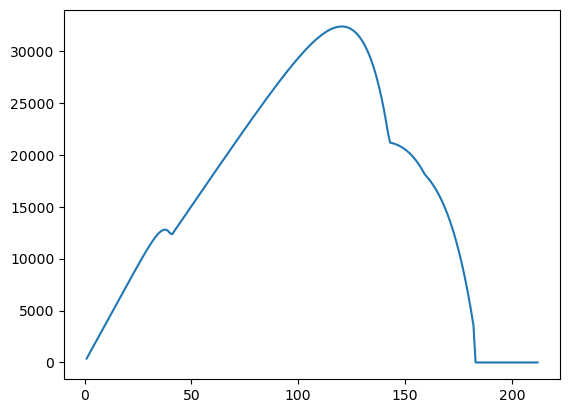

In [7]:
plt.plot(voltlst, powlst)